In [1]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter

In [3]:
import json

In [4]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

## Preprocessing

In [5]:
# loading the two datasets 

ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')


# loading the users dataset 

users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')

# loading the beers dataset

beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')

In [6]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

## Filter on location

In [7]:
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

US_country = 'United States'

# keep only the rows where the user country is United States
users_ba_df = users_ba_df[users_ba_df.location == US_country]
users_rb_df = users_rb_df[users_rb_df.location == US_country]

# merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df = pd.merge(ratings_ba_df, users_ba_df[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df = pd.merge(ratings_rb_df, users_rb_df[['user_id', 'location']], on='user_id', how='inner')

# filter the ratings dataframes to only keep the popular ratings of the users from the US
ratings_ba_df = ratings_users_ba_df[ratings_users_ba_df.location == US_country]
ratings_ba_df.drop('location', axis=1, inplace=True)
ratings_rb_df = ratings_users_rb_df[ratings_users_rb_df.location == US_country]
ratings_rb_df.drop('location', axis=1, inplace=True)

## Separate the good ratings and bad ratings

In [8]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


In [9]:
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()

# Filter the ratings dataframes to only keep the popular ratings
good_ratings_ba_df = ratings_ba_df[ratings_ba_df['rating'] > mean_ba]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df['rating'] > mean_rb]

bad_ratings_ba_df = ratings_ba_df[ratings_ba_df['rating'] <= mean_ba]
bad_ratings_rb_df = ratings_rb_df[ratings_rb_df['rating'] <= mean_rb]

In [10]:
# merge the two ratings data frames
good_ratings_combined_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)
bad_ratings_combined_df = pd.concat([bad_ratings_ba_df, bad_ratings_rb_df], ignore_index=True)

## Textual analysis

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
# drop rows where text is missing
good_ratings_combined_df.dropna(subset=['text'], inplace=True)
bad_ratings_combined_df.dropna(subset=['text'], inplace=True)

In [13]:
# Keywords for each category
aroma_keywords = ['aroma', 'smell', 'fragrance', 'scent', 'finish']
taste_keywords = ['taste', 'flavor', 'palate']
palate_keywords = ['palate', 'mouthfeel', 'body', 'texture', 'feel']
appearance_keywords = ['appearance', 'color', 'look', 'pour', 'head', 'foam', 'lacing']
carbonation_keywords = ['carbonation', 'bubbles', 'fizz', 'carbonated']

## Example

In [116]:
# Sample textual review
sample_review = """
This was a 12 oz bottle poured into a snifter.It pours a dark brown with some clarity but not truly transparent. 
It has a frothy head with mild retention and low lacing. By far the best thing this beer has going for it is a truly amazing malty aroma that does not disappoint. 
If only the taste delivered the same punch. It has a mild malt taste and is followed by a metallic finish. 
This could be due to being Ina bottle so I would try again on draft but it did let me down. 
The body is kind of weak with decent carbonation. I would buy again if the price was right but it didn't strike me as awesome.
"""

In [117]:
doc = nlp(sample_review)

In [118]:
# keep only the nouns and adjectives in a list 
pos_tag = ['ADJ']

# lowercase and lemmatize and remove stopwords and put the tokenized words in a list
token_list = [token.lemma_ for token in doc if token.pos_ in pos_tag and not token.is_stop]

In [165]:
def extract_keywords(text, keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        if token.text.lower() in keywords:
            # Collect nearby adjectives and nouns
            nearby_words = []
            for nearby_token in doc[token.i - 3:token.i + 5]:
                if nearby_token.pos_ in ['ADJ', 'NOUN'] and not nearby_token.is_stop and len(nearby_token) > 2:
                    nearby_words.append(nearby_token.lemma_)
            result.extend(nearby_words)
            
    # remove the duplicates and the words that are in the keywords list
    result = list(set(result) - set(keywords))

    return result

In [166]:
result = extract_keywords(sample_review, aroma_keywords)

In [167]:
result

['malty', 'amazing', 'metallic']

## Keywords extraction of the good reviews

In [126]:
# group by beer_id and count the number of reviews for each beer
beer_reviews_count = good_ratings_combined_df.groupby('beer_id').count()['text'].reset_index()

In [129]:
# print the average number of reviews
print("Average number of reviews per beer:", beer_reviews_count.text.mean())

Average number of reviews per beer: 13.480106777795909


In [132]:
beer_reviews_count.describe()

,beer_id,text
count,239001.000000,239001.000000
mean,221272.727223,13.480107
std,150582.412973,71.936676
min,1.000000,1.000000
25%,89204.000000,1.000000
50%,201842.000000,2.000000
75%,336505.000000,6.000000
max,536465.000000,4943.000000


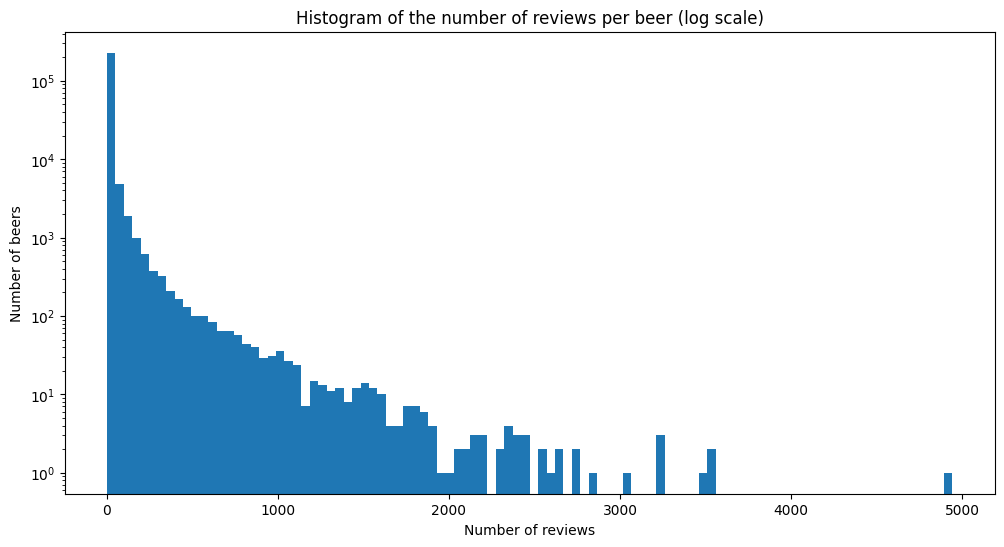

In [131]:
# plot histogram of the number of reviews with log scale
plt.figure(figsize=(12, 6))
plt.hist(beer_reviews_count.text, bins=100)
plt.xlabel('Number of reviews')
plt.ylabel('Number of beers')
plt.title('Histogram of the number of reviews per beer (log scale)')
plt.yscale('log')
plt.show()


The average of ratings received for a beer is 13.48, rounded to 14, with a standard deviation of 71.93. 
Since we have a lot of beers, and some of them receive a large amount of reviews, we decide to threshold the reviews. 
We assume that, in general, beers receive kind of the same review when it is a good review, and same goes for bad reviews. That's why we split the reviews into two parts, so that we can construct dictionnaries for good and for bad reviews.

Let's keep a maximum review of 100 for each beer. 

In [153]:
# for each beer_id, keep a maximum sample of 100 reviews
beer_reviews_sample = good_ratings_combined_df.groupby('beer_id').apply(lambda x: x.sample(min(len(x), 1))).reset_index(drop=True)

In [154]:
len(beer_reviews_sample)

239001

In [ ]:
good_aroma_list = []
good_taste_list = []
good_palate_list = []
good_appearance_list = []
good_carbonation_list = []

sample_reviews = good_ratings_combined_df['text'].sample(100000)

for i, text in enumerate(sample_reviews.values.tolist()):
    # for each keyword list, extract the keywords from the text
    good_aroma_list.extend(extract_keywords(text, aroma_keywords))
    good_taste_list.extend(extract_keywords(text, taste_keywords))
    good_palate_list.extend(extract_keywords(text, palate_keywords))
    good_appearance_list.extend(extract_keywords(text, appearance_keywords))
    good_carbonation_list.extend(extract_keywords(text, carbonation_keywords))
    
    aroma_set = Counter(good_aroma_list)
    taste_set = Counter(good_taste_list)
    palate_set = Counter(good_palate_list)
    appearance_set = Counter(good_appearance_list)
    carbonation_set = Counter(good_carbonation_list)
    
    if i % 1000 == 0:
        # save it into json files
        with open('data/aroma_keywords.json', 'w') as f:
            json.dump(aroma_set, f)
        
        with open('data/taste_keywords.json', 'w') as f:
            json.dump(taste_set, f)
        
        with open('data/palate_keywords.json', 'w') as f:
            json.dump(palate_set, f)
        
        with open('data/appearance_keywords.json', 'w') as f:
            json.dump(appearance_set, f)
        
        with open('data/carbonation_keywords.json', 'w') as f:
            json.dump(carbonation_set, f)
            
        print("File saved at iteration", i)

## Cleaning the list of keywords

In [23]:
# open the json files and load them into a dictionary
with open('data/aroma_keywords.json') as f:
    aroma_dict = json.load(f)

with open('data/taste_keywords.json') as f:
    taste_dict = json.load(f)
    
with open('data/palate_keywords.json') as f:
    palate_dict = json.load(f)

with open('data/appearance_keywords.json') as f:
    appearance_dict = json.load(f)
    
with open('data/carbonation_keywords.json') as f:
    carbonation_dict = json.load(f)

In [24]:
# concatenate all the keywords aroma_keywords, taste_keywords, palate_keywords, appearance_keywords, carbonation_keywords
all_keywords = aroma_keywords + taste_keywords + palate_keywords + appearance_keywords + carbonation_keywords

# create a function to filter the keys from the dictionary
def filter_keywords(keywords):
    filtered_keywords = []
    
    for keyword in keywords:
        
        # remove the keyowrds that have special characters, numbers and punctuation
        if not re.match('^[a-zA-Z]+$', keyword):
            continue
        
        # remove the keywords that are less than 3 characters
        if len(keyword) < 3:
            continue
        
        # remove keywords that have the word 'beer' in them
        if keyword == 'beer':
            continue
        
        # if the keyword is not in the all_keywords list, add it to the filtered_keywords list
        if keyword not in all_keywords:
            filtered_keywords.append(keyword)
    
    return filtered_keywords

In [25]:
# filter the keywords
aroma_words = filter_keywords(aroma_dict.keys())
taste_words = filter_keywords(taste_dict.keys())
palate_words = filter_keywords(palate_dict.keys())
appearance_words = filter_keywords(appearance_dict.keys())
carbonation_words = filter_keywords(carbonation_dict.keys())

# reconstruct the dictionaries with the filtered keywords
aroma_dict = {key: aroma_dict[key] for key in aroma_words}
taste_dict = {key: taste_dict[key] for key in taste_words}
palate_dict = {key: palate_dict[key] for key in palate_words}
appearance_dict = {key: appearance_dict[key] for key in appearance_words}
carbonation_dict = {key: carbonation_dict[key] for key in carbonation_words}


In [28]:
# sort the dictionaries by value
aroma_dict = dict(sorted(aroma_dict.items(), key=lambda item: item[1], reverse=True))
taste_dict = dict(sorted(taste_dict.items(), key=lambda item: item[1], reverse=True))
palate_dict = dict(sorted(palate_dict.items(), key=lambda item: item[1], reverse=True))
appearance_dict = dict(sorted(appearance_dict.items(), key=lambda item: item[1], reverse=True))
carbonation_dict = dict(sorted(carbonation_dict.items(), key=lambda item: item[1], reverse=True))

aroma_dict

{'sweet': 6277,
 'dry': 5425,
 'nice': 4997,
 'hop': 4980,
 'bitter': 4371,
 'malt': 4114,
 'light': 3244,
 'citrus': 2891,
 'white': 2812,
 'chocolate': 2799,
 'good': 2583,
 'medium': 2152,
 'fruit': 2143,
 'coffee': 2083,
 'fruity': 1987,
 'strong': 1926,
 'roasted': 1798,
 'dark': 1738,
 'note': 1682,
 'hoppy': 1640,
 'bitterness': 1627,
 'floral': 1574,
 'smooth': 1436,
 'bit': 1406,
 'clean': 1384,
 'alcohol': 1354,
 'caramel': 1284,
 'big': 1284,
 'glass': 1272,
 'great': 1261,
 'sour': 1256,
 'tart': 1238,
 'pine': 1236,
 'long': 1232,
 'spicy': 1218,
 'yeast': 1141,
 'slight': 1081,
 'mild': 1068,
 'little': 1064,
 'hint': 1023,
 'grapefruit': 989,
 'malty': 988,
 'lot': 961,
 'earthy': 930,
 'spice': 911,
 'rich': 891,
 'crisp': 880,
 'roasty': 850,
 'cherry': 788,
 'brown': 769,
 'vanilla': 767,
 'lace': 750,
 'moderate': 732,
 'fresh': 729,
 'sweetness': 669,
 'bourbon': 657,
 'pleasant': 639,
 'heavy': 635,
 'lemon': 635,
 'overall': 615,
 'citrusy': 602,
 'complex': 596,


In [29]:
# print the size of each dictionary
print("Number of aroma keywords:", len(aroma_dict))
print("Number of taste keywords:", len(taste_dict))
print("Number of palate keywords:", len(palate_dict))
print("Number of appearance keywords:", len(appearance_dict))
print("Number of carbonation keywords:", len(carbonation_dict))

Number of aroma keywords: 5683
Number of taste keywords: 5948
Number of palate keywords: 4818
Number of appearance keywords: 6426
Number of carbonation keywords: 3119
